In [1]:
import stata_setup
import pandas as pd
stata_setup.config("/Applications/STATA","se")


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user , expiring 31 Aug 2023
Serial number: 401709320927
  Licensed to: Bruno Komel
               University of Pittsburgh

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
%%stata

global recitation "~/Documents/Pitt/Year_2/TA - Econ 3080/Recitations/Recitation 8 - Fuzzy RDD"
cd "${recitation}"

// Thanks to https://evalf20.classes.andrewheiss.com/example/rdd-fuzzy/#fuzzy-parametric-estimation for this
import delimited "tutoring_program_fuzzy.csv", clear 


. 
. global recitation "~/Documents/Pitt/Year_2/TA - Econ 3080/Recitations/Recitat
> ion 8 - Fuzzy RDD"

. cd "${recitation}"
/Users/brunokomel/Documents/Pitt/Year_2/TA - Econ 3080/Recitations/Recitation 8
>  - Fuzzy RDD

. 
. // Thanks to https://evalf20.classes.andrewheiss.com/example/rdd-fuzzy/#fuzzy
> -parametric-estimation for this
. import delimited "tutoring_program_fuzzy.csv", clear 
(encoding automatically selected: ISO-8859-1)
(5 vars, 1,000 obs)

. 


**Here's the setting:
* Students take an entrance exam at the beginning of the school year
* If they score 70 or below, they are enrolled in a free tutoring program
* BUT we have some non-compliers. Both always takers and never takers.
* Students take an exit exam at the end of the year


. 
. // So, let's take a look at what we have:
. 
. xi: twoway scatter i.tutoring_text entrance_exam, xline(70, lcolor(red)) 
i.tutoring_text   _Itutoring__1-2     (_Itutoring__1 for tut~t==No tutor omitte
> d)

.     
. // The first thing that we can notice is that the cutoff is not strict. 
. //There are observations on both sides of the cutoff that fall in either cate
> gory.
. 


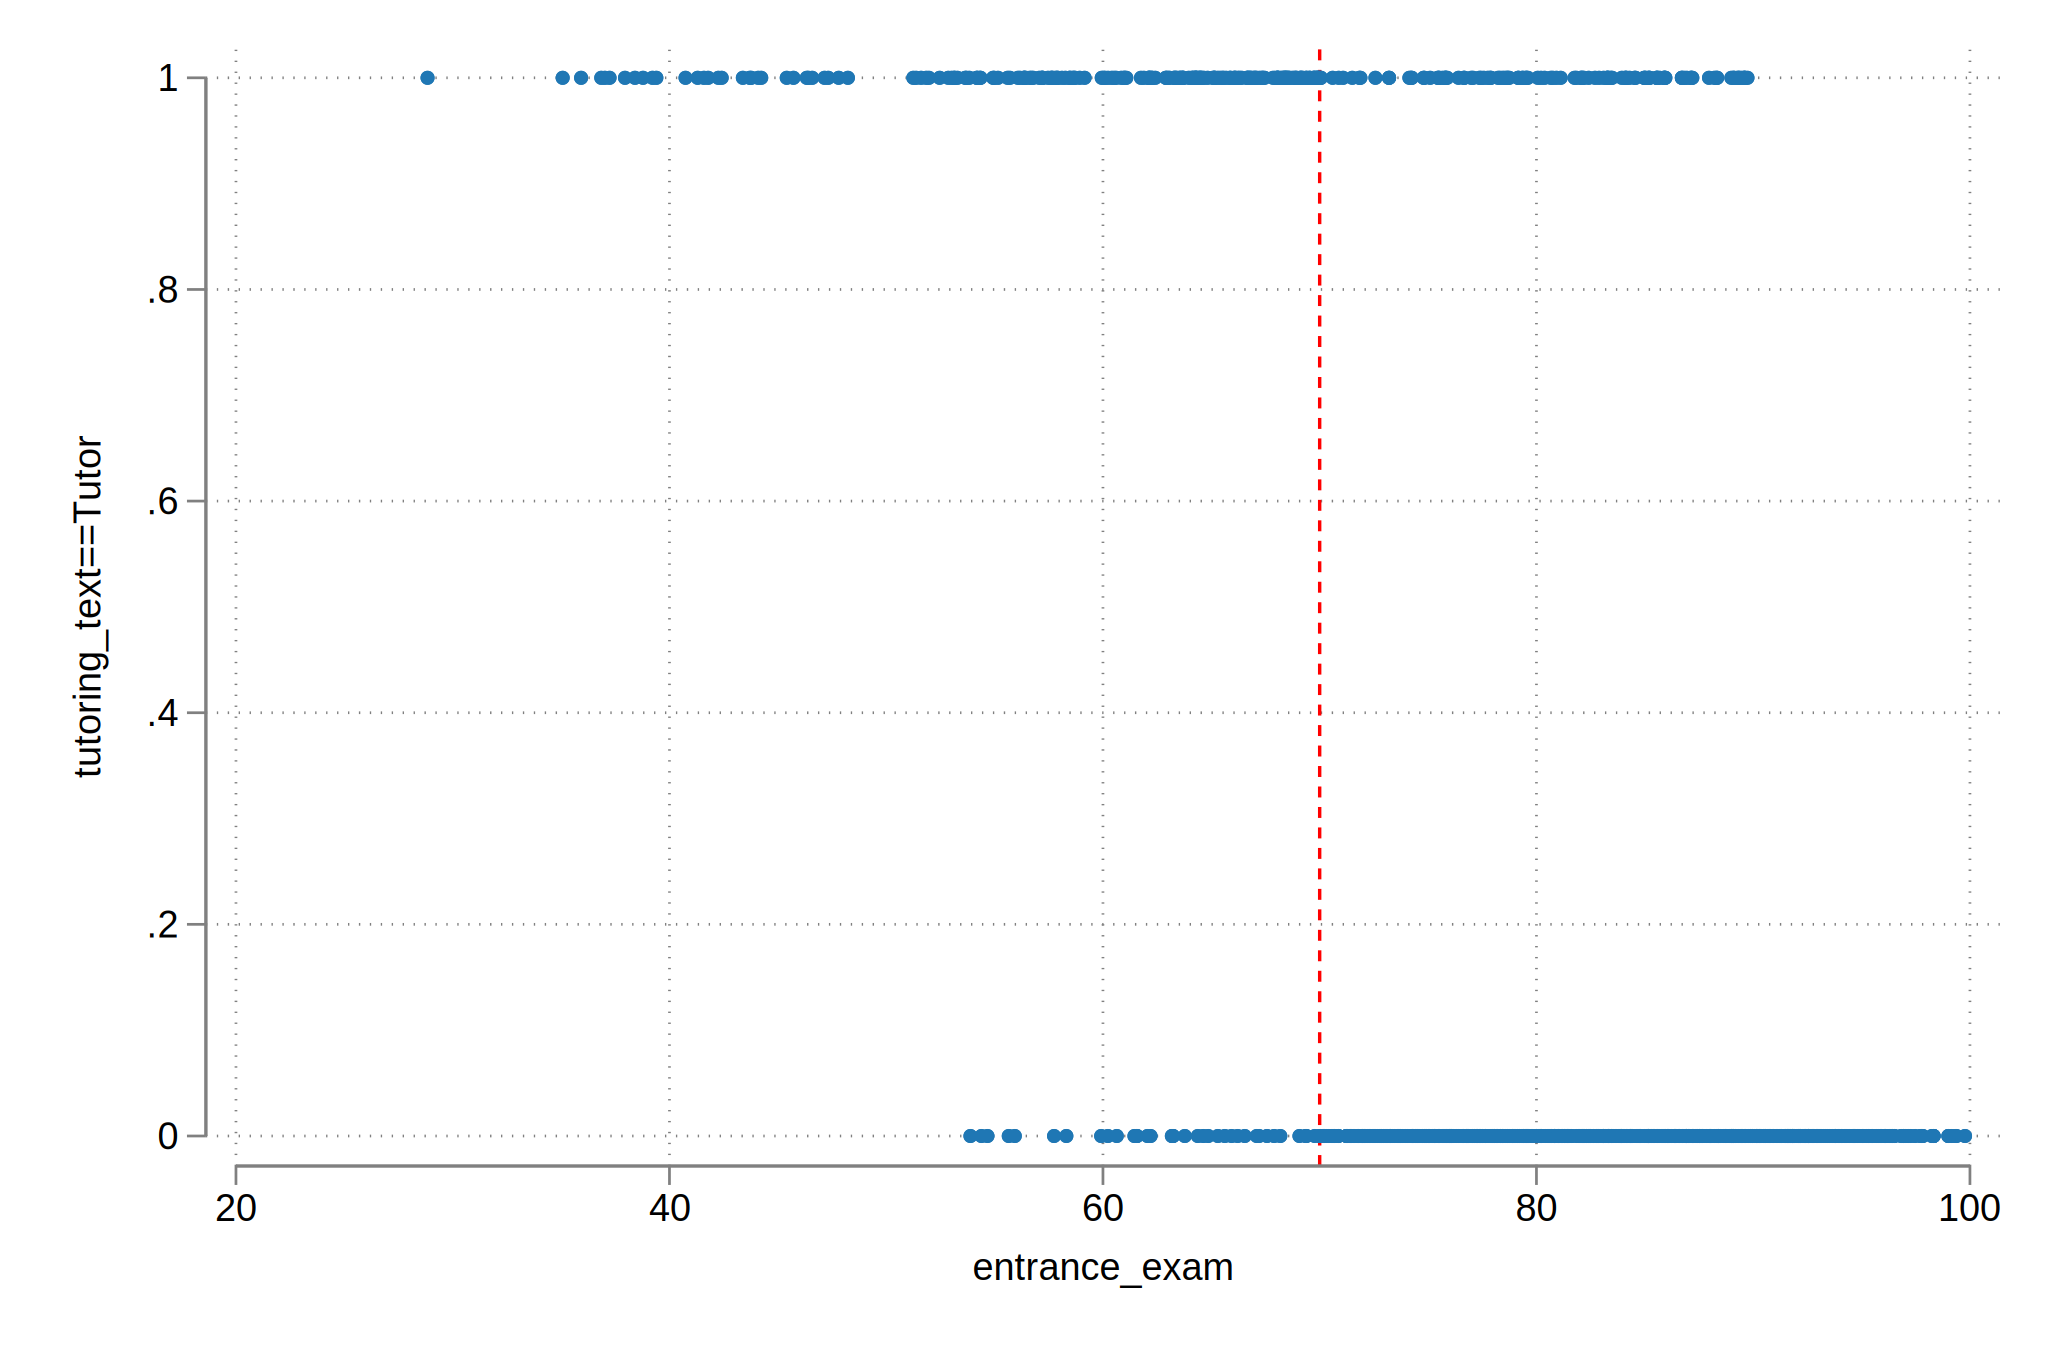

In [3]:
%%stata

// So, let's take a look at what we have:

xi: twoway scatter i.tutoring_text entrance_exam, xline(70, lcolor(red)) 
    
// The first thing that we can notice is that the cutoff is not strict. 
//There are observations on both sides of the cutoff that fall in either category.

In [4]:
%%stata

// Next, we should try to get an idea of how many people are in each group (compliers, non-compliers, etc)
// Let's generate a dummy for the "treatment," which would have been assigned if we had a sharp RDD
gen below_cutoff = 0
replace below_cutoff = 1 if entrance_exam <= 70

tab tutoring, gen(tutoring)

bysort below_cutoff tutoring2: sum tutoring2


. 
. // Next, we should try to get an idea of how many people are in each group (c
> ompliers, non-compliers, etc)
. // Let's generate a dummy for the "treatment," which would have been assigned
>  if we had a sharp RDD
. gen below_cutoff = 0

. replace below_cutoff = 1 if entrance_exam <= 70
(238 real changes made)

. 
. tab tutoring, gen(tutoring)

   tutoring |      Freq.     Percent        Cum.
------------+-----------------------------------
      FALSE |        682       68.20       68.20
       TRUE |        318       31.80      100.00
------------+-----------------------------------
      Total |      1,000      100.00

. 
. bysort below_cutoff tutoring2: sum tutoring2

-------------------------------------------------------------------------------
-> below_cutoff = 0, tutoring2 = 0

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
   tutoring2 |        646           0           0   


. 
. // Let's see if we can find some discontinuity in the plots?
. twoway (scatter exit_exam entrance_exam if tutoring2 == 1 ) ///
>         (scatter exit_exam entrance_exam if tutoring2 == 0) ///
>         (lfitci  exit_exam entrance_exam if tutoring2 == 1& entrance_exam <= 
> 70 , ciplot(rline) color(red)) ///
>         (lfitci  exit_exam entrance_exam if tutoring2 == 1& entrance_exam > 7
> 0 , ciplot(rline) color(red)) ///
>         (lfitci  exit_exam entrance_exam if tutoring2 == 0& entrance_exam <= 
> 70 ,  ciplot(rarea) color(green)) ///
>         (lfitci  exit_exam entrance_exam if tutoring2 == 0& entrance_exam > 7
> 0 , ciplot(rarea) color(green)), /// 
>         legend(lab(1 "With Tutoring") lab(2 "No Tutoring") lab(4 "Tutoring Be
> low Fit.") ///
>         lab(6 "Tutoring Above Fit.") lab(8 "No Tut. Below Fit.") lab(10 "No T
> ut. Above Fit."))

. 


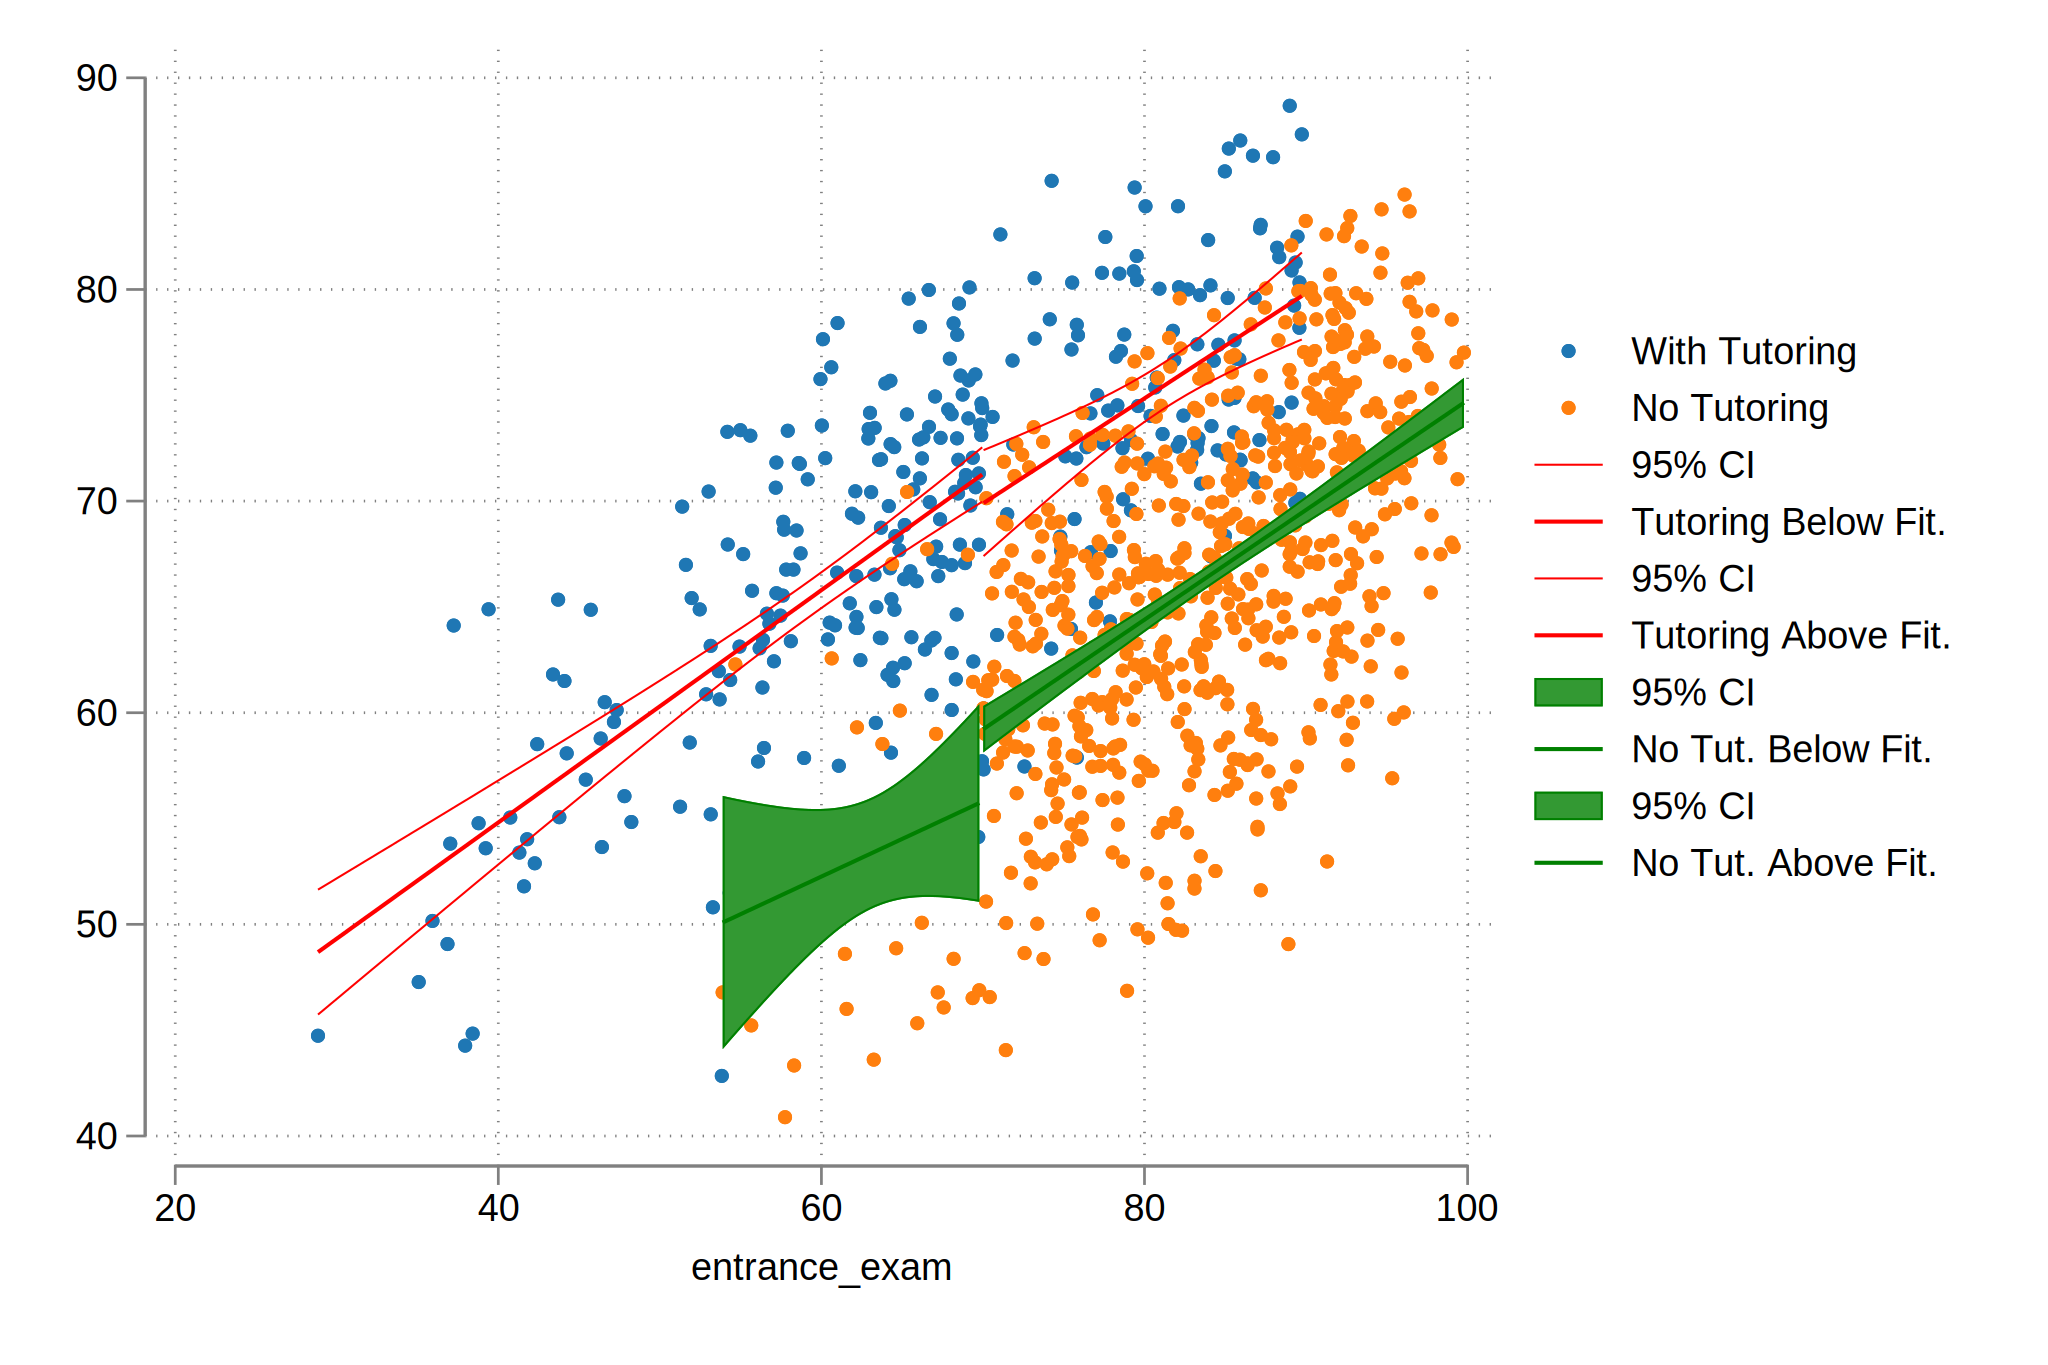

In [5]:
%%stata

// Let's see if we can find some discontinuity in the plots?
twoway (scatter exit_exam entrance_exam if tutoring2 == 1 ) ///
	(scatter exit_exam entrance_exam if tutoring2 == 0) ///
	(lfitci  exit_exam entrance_exam if tutoring2 == 1& entrance_exam <= 70 , ciplot(rline) color(red)) ///
	(lfitci  exit_exam entrance_exam if tutoring2 == 1& entrance_exam > 70 , ciplot(rline) color(red)) ///
	(lfitci  exit_exam entrance_exam if tutoring2 == 0& entrance_exam <= 70 ,  ciplot(rarea) color(green)) ///
	(lfitci  exit_exam entrance_exam if tutoring2 == 0& entrance_exam > 70 , ciplot(rarea) color(green)), /// 
	legend(lab(1 "With Tutoring") lab(2 "No Tutoring") lab(4 "Tutoring Below Fit.") ///
	lab(6 "Tutoring Above Fit.") lab(8 "No Tut. Below Fit.") lab(10 "No Tut. Above Fit."))

In [6]:
%%stata


// Next, just so we can get an idea of how many compliers, and non-compliers we have, let's plot this
// differently. Here I want to see the probability of receiving tutoring for the different socres that 
// people received, using bins of 5 points each.

// To use the twoway bar command, we need to create a categorical variable for each score bin
gen entr_score_cat =0

forvalues i = 25(5)95{
	replace entr_score_cat = `i'/5 - 5 if entrance_exam > `i' & entrance_exam <= `i'+5
}



. 
. 
. // Next, just so we can get an idea of how many compliers, and non-compliers 
> we have, let's plot this
. // differently. Here I want to see the probability of receiving tutoring for 
> the different socres that 
. // people received, using bins of 5 points each.
. 
. // To use the twoway bar command, we need to create a categorical variable fo
> r each score bin
. gen entr_score_cat =0

. 
. forvalues i = 25(5)95{
  2.         replace entr_score_cat = `i'/5 - 5 if entrance_exam > `i' & entran
> ce_exam <= `i'+5
  3. }
(0 real changes made)
(0 real changes made)
(10 real changes made)
(11 real changes made)
(9 real changes made)
(23 real changes made)
(38 real changes made)
(63 real changes made)
(83 real changes made)
(108 real changes made)
(149 real changes made)
(157 real changes made)
(165 real changes made)
(134 real changes made)
(49 real changes made)

. 


In [7]:
%%stata

// And add a label so it looks slightly better
forvalues i = 25(5)95{
	label define entr_score_cat_lab `=`i'/5 - 5' "`=`i'+1' - `=`i'+5'" , add
}


// I want to highlight what we're doing here, because it's not trivial.
// Using the index `i' inside the loop tells stata to use whatever value of `i' is currently "running" 
// in the loop.
// But what if you want a lagged index value? Or one with a lead?
// Then you need to use `= `i' + 1' . Where you're basically running a small equation inside the ` ' 


. 
. // And add a label so it looks slightly better
. forvalues i = 25(5)95{
  2.         label define entr_score_cat_lab `=`i'/5 - 5' "`=`i'+1' - `=`i'+5'"
>  , add
  3. }

. 
. 
. // I want to highlight what we're doing here, because it's not trivial.
. // Using the index `i' inside the loop tells stata to use whatever value of `
> i' is currently "running" 
. // in the loop.
. // But what if you want a lagged index value? Or one with a lead?
. // Then you need to use `= `i' + 1' . Where you're basically running a small 
> equation inside the ` ' 
. 


In [8]:
%%stata

label values entr_score_cat entr_score_cat_lab

save recitation8_data, replace


. 
. label values entr_score_cat entr_score_cat_lab

. 
. save recitation8_data, replace
file recitation8_data.dta saved

. 


In [9]:
%%stata -doutd df2

use recitation8_data, replace


. 
. use recitation8_data, replace

. 


In [10]:
display(df2)
# Note that in Stata, this would the "entr_score_cat" would display as the labels we attached

,id,entrance_exam,tutoring,tutoring_text,exit_exam,_Itutoring__2,below_cutoff,tutoring1,tutoring2,entr_score_cat
0,1,92.408325,FALSE,No tutor,78.075920,0,0.0,1,0,13.0
1,818,76.021858,FALSE,No tutor,63.546421,0,0.0,1,0,10.0
2,1000,83.472427,FALSE,No tutor,61.067234,0,0.0,1,0,11.0
3,516,89.113045,FALSE,No tutor,75.590050,0,0.0,1,0,12.0
4,62,71.609581,FALSE,No tutor,59.862137,0,0.0,1,0,9.0
...,...,...,...,...,...,...,...,...,...,...
995,443,69.749588,TRUE,Tutor,71.308792,1,1.0,0,1,8.0
996,778,60.031471,TRUE,Tutor,73.571014,1,1.0,0,1,7.0
997,5,69.712196,TRUE,Tutor,54.128883,1,1.0,0,1,8.0
998,982,58.482834,TRUE,Tutor,52.697124,1,1.0,0,1,6.0


In [11]:
%%stata

// And to get the probability, we need to generate a "frequency" by taking the mean of the dummy variable 
// over the number of observarions in each category

egen frequency = mean(tutoring2), by(entr_score_cat)


. 
. // And to get the probability, we need to generate a "frequency" by taking th
> e mean of the dummy variable 
. // over the number of observarions in each category
. 
. egen frequency = mean(tutoring2), by(entr_score_cat)

. 



. 
. graph bar tutoring2, over(entr_score_cat, gap(100)) outergap(*1.2) ytitle("Pr
> obability of Receiving Tutoring")

. 


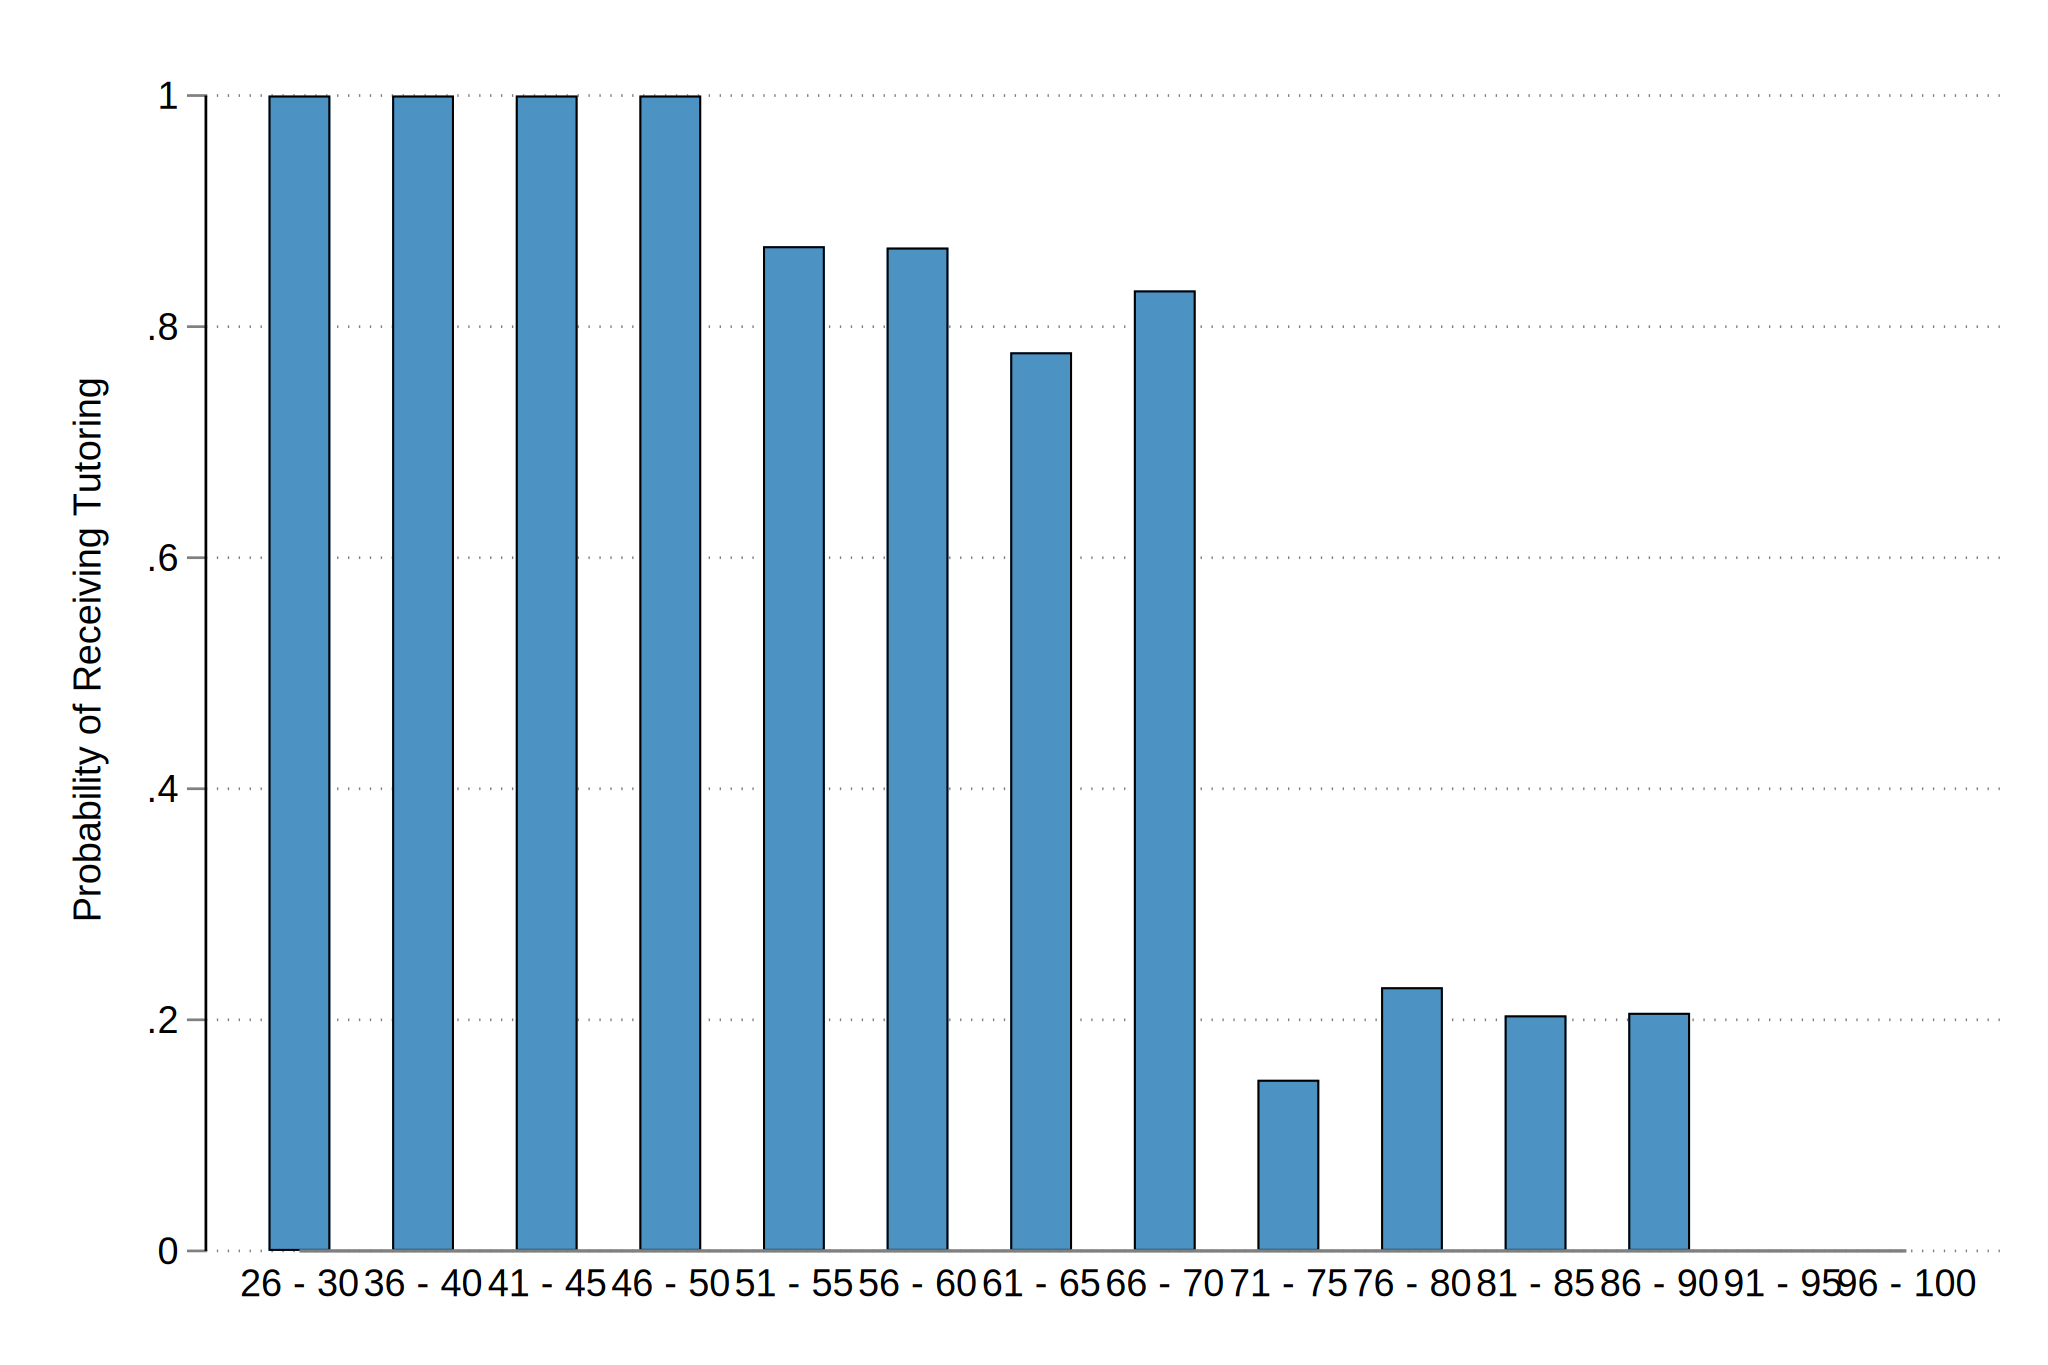

In [12]:
%%stata

graph bar tutoring2, over(entr_score_cat, gap(100)) outergap(*1.2) ytitle("Probability of Receiving Tutoring")


. 
. 
. twoway (bar frequency  entr_score_cat,  xline(8.5, lwidth(thick) lcolor(red))
>  ///
>         xlabel(0(1)14,valuelabel alternate) barwidth(0.8)  ytitle("Probabilit
> y of Receiving Tutoring") ///
>         xtitle("Entrance Exam Score") )

. 


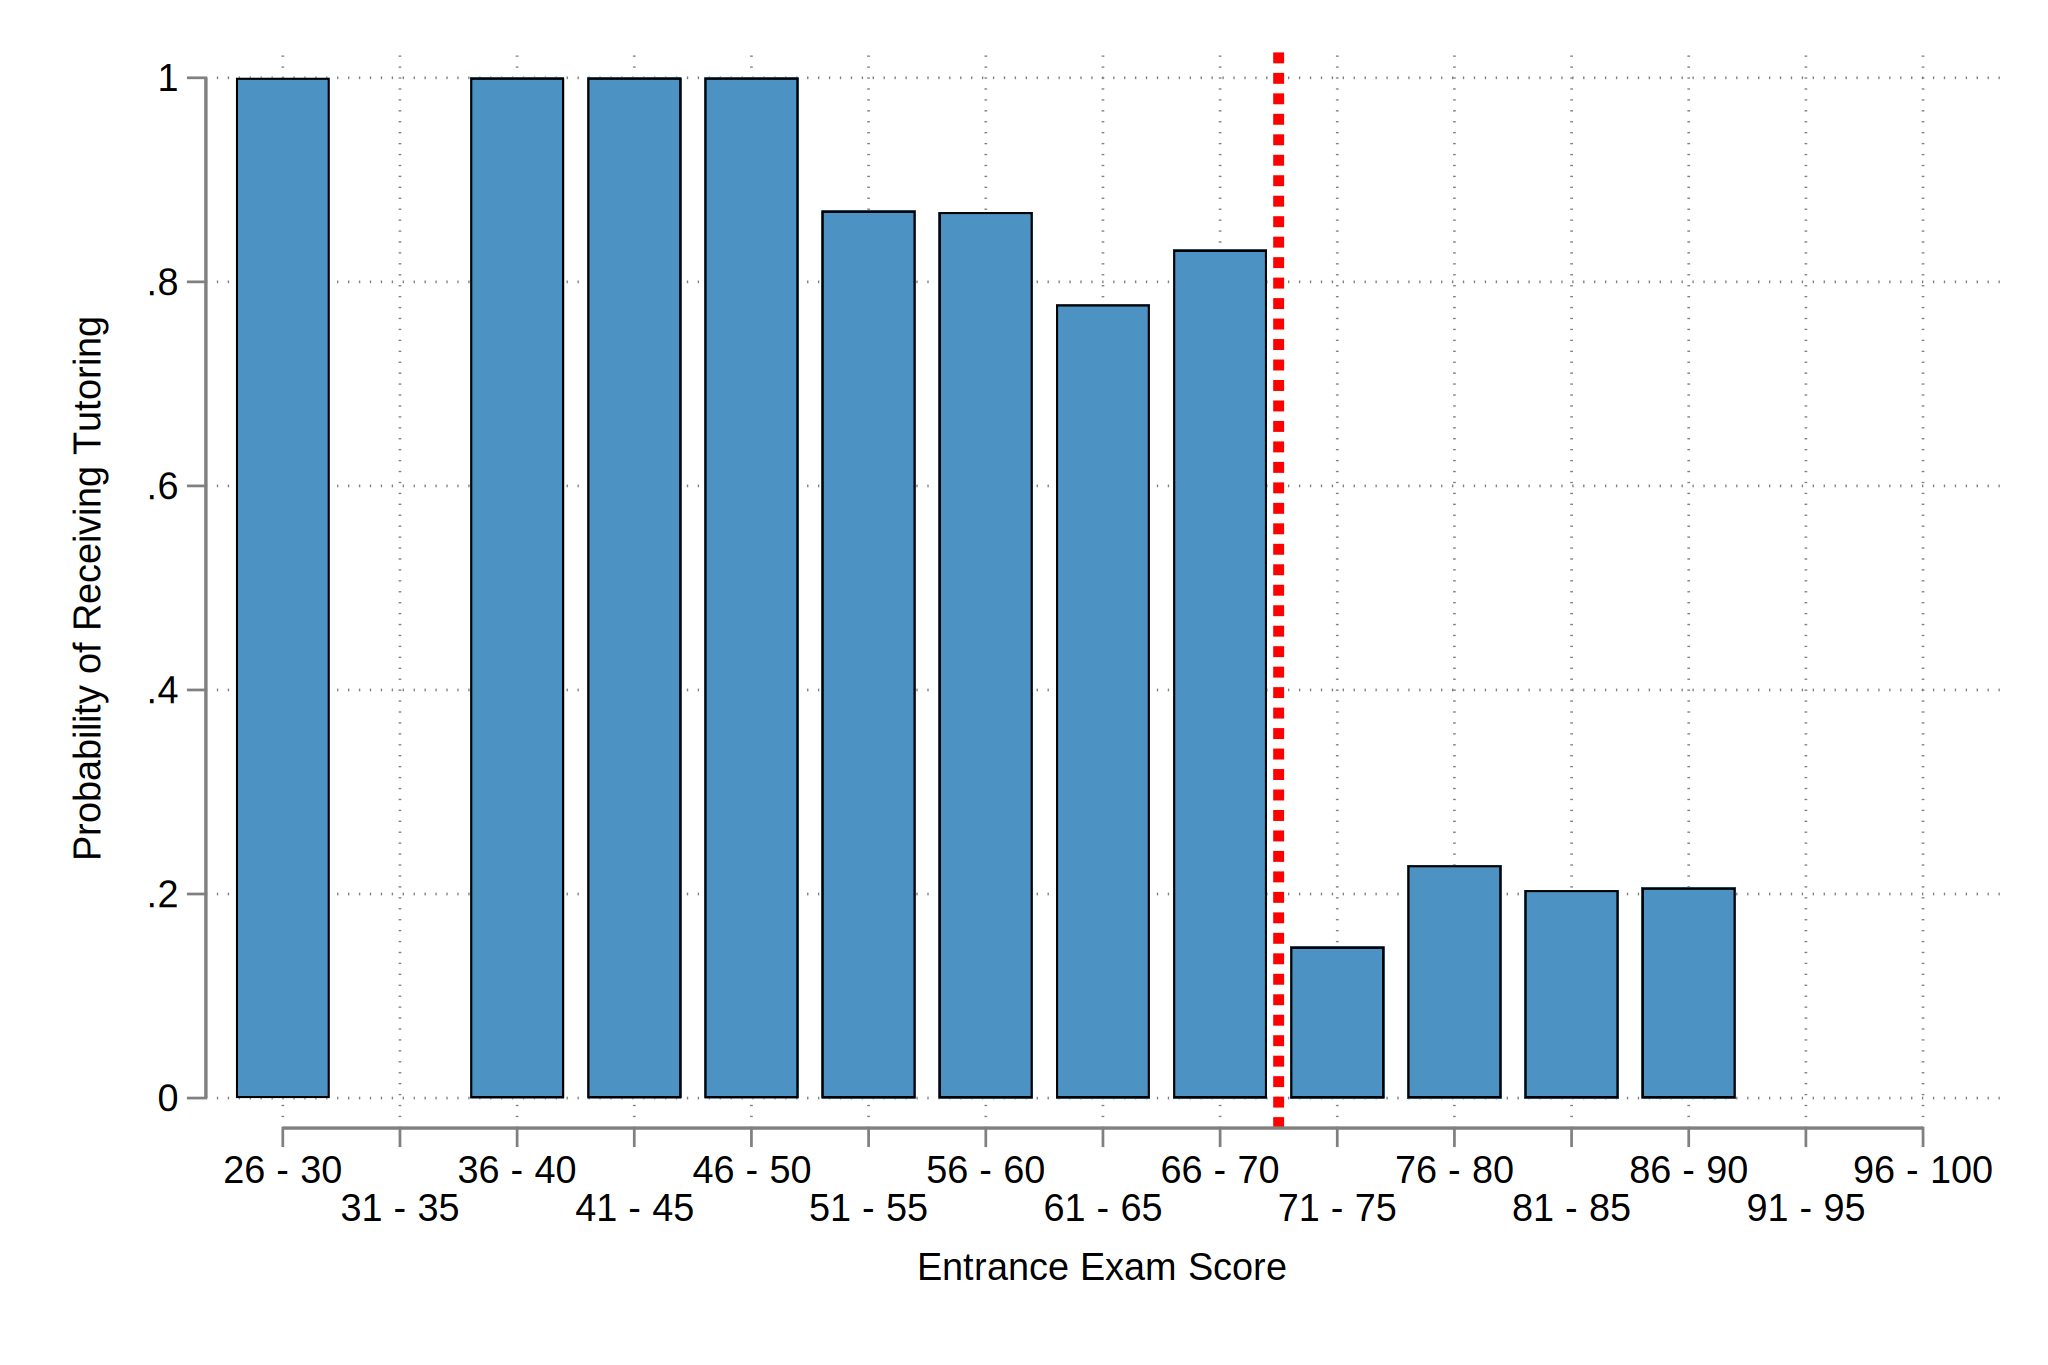

In [13]:
%%stata


twoway (bar frequency  entr_score_cat,  xline(8.5, lwidth(thick) lcolor(red)) ///
        xlabel(0(1)14,valuelabel alternate) barwidth(0.8)  ytitle("Probability of Receiving Tutoring") ///
        xtitle("Entrance Exam Score") )

In [14]:
%%stata

// The key here is that some students above the cut-off receive tutoring, and some below the cut-off do not

// Next, let's recenter our running variable
gen entrance_centered = entrance_exam - 70

// recall we've generated below_cutoff


. 
. // The key here is that some students above the cut-off receive tutoring, and
>  some below the cut-off do not
. 
. // Next, let's recenter our running variable
. gen entrance_centered = entrance_exam - 70

. 
. // recall we've generated below_cutoff
. 


In [15]:
%%stata


// Let's pretend this is a sharp RDD scenario:
// first let's label some stuff
label variable exit_exam "Exit Exam"
label variable tutoring2 "Received Tutoring"


. 
. 
. // Let's pretend this is a sharp RDD scenario:
. // first let's label some stuff
. label variable exit_exam "Exit Exam"

. label variable tutoring2 "Received Tutoring"

. 


In [16]:
%%stata


// And let's store our regressions to create a nice table 
eststo OLS: reg exit_exam entrance_centered tutoring2 if (entrance_centered >= -10 & entrance_centered <=10)
    estadd scalar BW = 10
// In this case we'd estimate an effect of 11.48
// Note that I want to keep track of the size of the bandwidth for each of these regressions


. 
. 
. // And let's store our regressions to create a nice table 
. eststo OLS: reg exit_exam entrance_centered tutoring2 if (entrance_centered >
> = -10 & entrance_centered <=10)

      Source |       SS           df       MS      Number of obs   =       403
-------------+----------------------------------   F(2, 400)       =    119.10
       Model |  9956.07367         2  4978.03684   Prob > F        =    0.0000
    Residual |  16718.3806       400  41.7959515   R-squared       =    0.3732
-------------+----------------------------------   Adj R-squared   =    0.3701
       Total |  26674.4543       402  66.3543638   Root MSE        =     6.465

------------------------------------------------------------------------------
   exit_exam | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
entrance_c~d |   .5113075    .066504     7.69   0.000     .3805665    .6420484
   tutoring2 |   11.48445 

In [17]:
%%stata
// ssc install ivreg2
// ssc install ranktest

eststo IV: ivreg2 exit_exam entrance_centered ( tutoring2 = below_cutoff ) ///
    if (entrance_centered >= -10 & entrance_centered <=10), robust 
    estadd scalar BW = 10
// Now the coefficeint dropped to 9.74. This is the effect on compliers in the bandwidth (which we chose)


. // ssc install ivreg2
. // ssc install ranktest
. 
. eststo IV: ivreg2 exit_exam entrance_centered ( tutoring2 = below_cutoff ) //
> /
>     if (entrance_centered >= -10 & entrance_centered <=10), robust 

IV (2SLS) estimation
--------------------

Estimates efficient for homoskedasticity only
Statistics robust to heteroskedasticity

                                                      Number of obs =      403
                                                      F(  2,   400) =    13.09
                                                      Prob > F      =   0.0000
Total (centered) SS     =  26674.45427                Centered R2   =   0.3646
Total (uncentered) SS   =  1730599.761                Uncentered R2 =   0.9902
Residual SS             =  16947.71143                Root MSE      =    6.485

------------------------------------------------------------------------------
             |               Robust
   exit_exam | Coefficient  std. err.      z    P>|z|     [95% conf. in

In [18]:
%%stata

eststo RDrob: rdrobust exit_exam entrance_centered, fuzzy(tutoring2) c(0)
    estadd scalar BW = e(h_r)
// And here it's pretty close to the 2sls
// Note that you do not need to specify an insrtument with rdrobust.


. 
. eststo RDrob: rdrobust exit_exam entrance_centered, fuzzy(tutoring2) c(0)

Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       100
> 0
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |       238         762            Kernel        = Triangula
> r
Eff. Number of obs |       170         347            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    12.985      12.985
       BW bias (b) |    19.733      19.733
         rho (h/b) |     0.658       0.658

First-stage estimates. Outcome: tutoring2. Running variable: entrance_centered.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+--------------------------------------------

In [19]:
%%stata

global latex "/Users/brunokomel/Library/CloudStorage/Dropbox/Apps/Overleaf/Recitation - Tables"
cd "${latex}"

// Using this method we get pretty close results!
esttab OLS IV RDrob using "table1.tex",  sfmt(4) b(3) se(2) keep(tutoring2 RD_Estimate) ///
varlabel(RD_Estimate "Received Tutoring (Non-Parametric)") label mtitles("OLS" "2SLS" "RD Robust") ///
scalars("N Observations" "BW Bandwidth Choice") fragment replace

/// Here, esttab will tell stata to compile your table
/// using creates, or overwrites, a .tex file where your table will go (it'll go to the working directory)
/// sfmt(x) will tell stata to show x characters after the decimal point for the "general table values" (catch-all)
/// b(x) will tell stata to show x characters after the decimal point for the BETA coefficients
/// se(x) will tell stata to show x characters after the decimal point for the STANDARD ERROS
/// varlabel(z " Z " ) tells stata to label, on the table, the variable z as " Z "
/// label tells stata to use the labels of the variables that have labels
/// mtitles("Col 1 " "Col 2" ...) assigns column titles to each of the estimates that you stored and appended
/// scalars("X Name of X you want" ...) tells stata to output the stored scalar/local "X" and give it the name that you want 
/// fragment tells stata that there will be more esttab's coming to append a table, and it removes some automatic things (like star captions)                                                                        
/// replace will automatically save over the table that you previously created


. 
. global latex "/Users/brunokomel/Library/CloudStorage/Dropbox/Apps/Overleaf/Re
> citation - Tables"

. cd "${latex}"
/Users/brunokomel/Library/CloudStorage/Dropbox/Apps/Overleaf/Recitation - Table
> s

. 
. // Using this method we get pretty close results!
. esttab OLS IV RDrob using "table11.tex",  sfmt(4) b(3) se(2) keep(tutoring2 R
> D_Estimate) ///
> varlabel(RD_Estimate "Received Tutoring (Non-Parametric)") label mtitles("OLS
> " "2SLS" "RD Robust") ///
> scalars("N Observations" "BW Bandwidth Choice") fragment replace
(output written to table11.tex)

. 
. /// Here, esttab will tell stata to compile your table
> /// using creates, or overwrites, a .tex file where your table will go (it'll
>  go to the working directory)
> /// sfmt(x) will tell stata to show x characters after the decimal point for 
> the "general table values" (catch-all)
> /// b(x) will tell stata to show x characters after the decimal point for the
>  BETA coefficients
> /// se(x) will tell stata to show x 

In [20]:
%%stata 

esttab OLS IV RDrob ,  sfmt(4) b(3) se(2) keep(tutoring2 RD_Estimate) ///
varlabel(RD_Estimate "Received Tutoring (Non-Parametric)") label mtitles("OLS" "2SLS" "RD Robust") ///
scalars("N Observations" "BW Bandwidth Choice") fragment 


. 
. esttab OLS IV RDrob ,  sfmt(4) b(3) se(2) keep(tutoring2 RD_Estimate) ///
> varlabel(RD_Estimate "Received Tutoring (Non-Parametric)") label mtitles("OLS
> " "2SLS" "RD Robust") ///
> scalars("N Observations" "BW Bandwidth Choice") fragment 

                              (1)             (2)             (3)   
                              OLS            2SLS       RD Robust   
--------------------------------------------------------------------
Received Tutoring          11.484***        9.741***                
                           (0.74)          (1.90)                   
Received Tutoring ~i                                        9.683***
                                                           (1.89)   
--------------------------------------------------------------------
Observations                  403             403            1000   
Bandwidth Choice          10.0000         10.0000         12.9852   

. 


# Exercise

In [40]:
%%stata

cd "${recitation}"

use analysis.dta, clear

// From Vincent Ponz and Clemente Tricaud's papper 
// "Expressive Voting and its Cost: Evidence from Runoffs With Two or Three Candidates"
// Econometrica 2018
//https://www.econometricsociety.org/publications/econometrica/2018/09/01/expressive-voting-and-its-cost-evidence-runoffs-two-or-three


. 
. cd "${recitation}"
/Users/brunokomel/Documents/Pitt/Year_2/TA - Econ 3080/Recitations/Recitation 8
>  - Fuzzy RDD

. 
. use analysis.dta, clear

. 
. // From Vincent Ponz and Clemente Tricaud's papper 
. // "Expressive Voting and its Cost: Evidence from Runoffs With Two or Three C
> andidates"
. // Econometrica 2018
. //https://www.econometricsociety.org/publications/econometrica/2018/09/01/exp
> ressive-voting-and-its-cost-evidence-runoffs-two-or-three
. 


In [41]:
%%stata

use analysis.dta, clear


. 
. use analysis.dta, clear

. 


In [42]:
%%stata

keep prop_registered_turnout_R2 running treatment assignment prop_registered_blanknull_R2 ///
prop_registered_candvotes_R2 year prop_registered_votes_cand3_R1

rename prop_registered_votes_cand3_R1 running_uncentered
rename prop_registered_turnout_R2 turnout
rename prop_registered_blanknull_R2 blanknull
rename prop_registered_candvotes_R2 candvotes


. 
. keep prop_registered_turnout_R2 running treatment assignment prop_registered_
> blanknull_R2 ///
> prop_registered_candvotes_R2 year prop_registered_votes_cand3_R1

. 
. rename prop_registered_votes_cand3_R1 running_uncentered

. rename prop_registered_turnout_R2 turnout

. rename prop_registered_blanknull_R2 blanknull

. rename prop_registered_candvotes_R2 candvotes

. 



. 
. // Let's plot some stuff so we get an idea of what's happening
. // First, the "first stage"
. rdplot treatment running, p(1) graph_options(title("") ///
>     ytitle(Treatment status) xtitle(Running variable) graphregion(color(white
> )) ///
>     legend(off) ylabel(0 (.2) 1) xlabel(-.1 (.05) .1))) nbins(20 20)

RD Plot with RD plot with manually set number of bins.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       725
> 7
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |      6042        1215
   Eff. Number of obs |      6041        1215
  Order poly. fit (p) |         1           1
     BW poly. fit (h) |     0.121       0.125
 Number of bins scale |     1.000       1.000

Outcome: treatment. Running variable: running.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |         1      

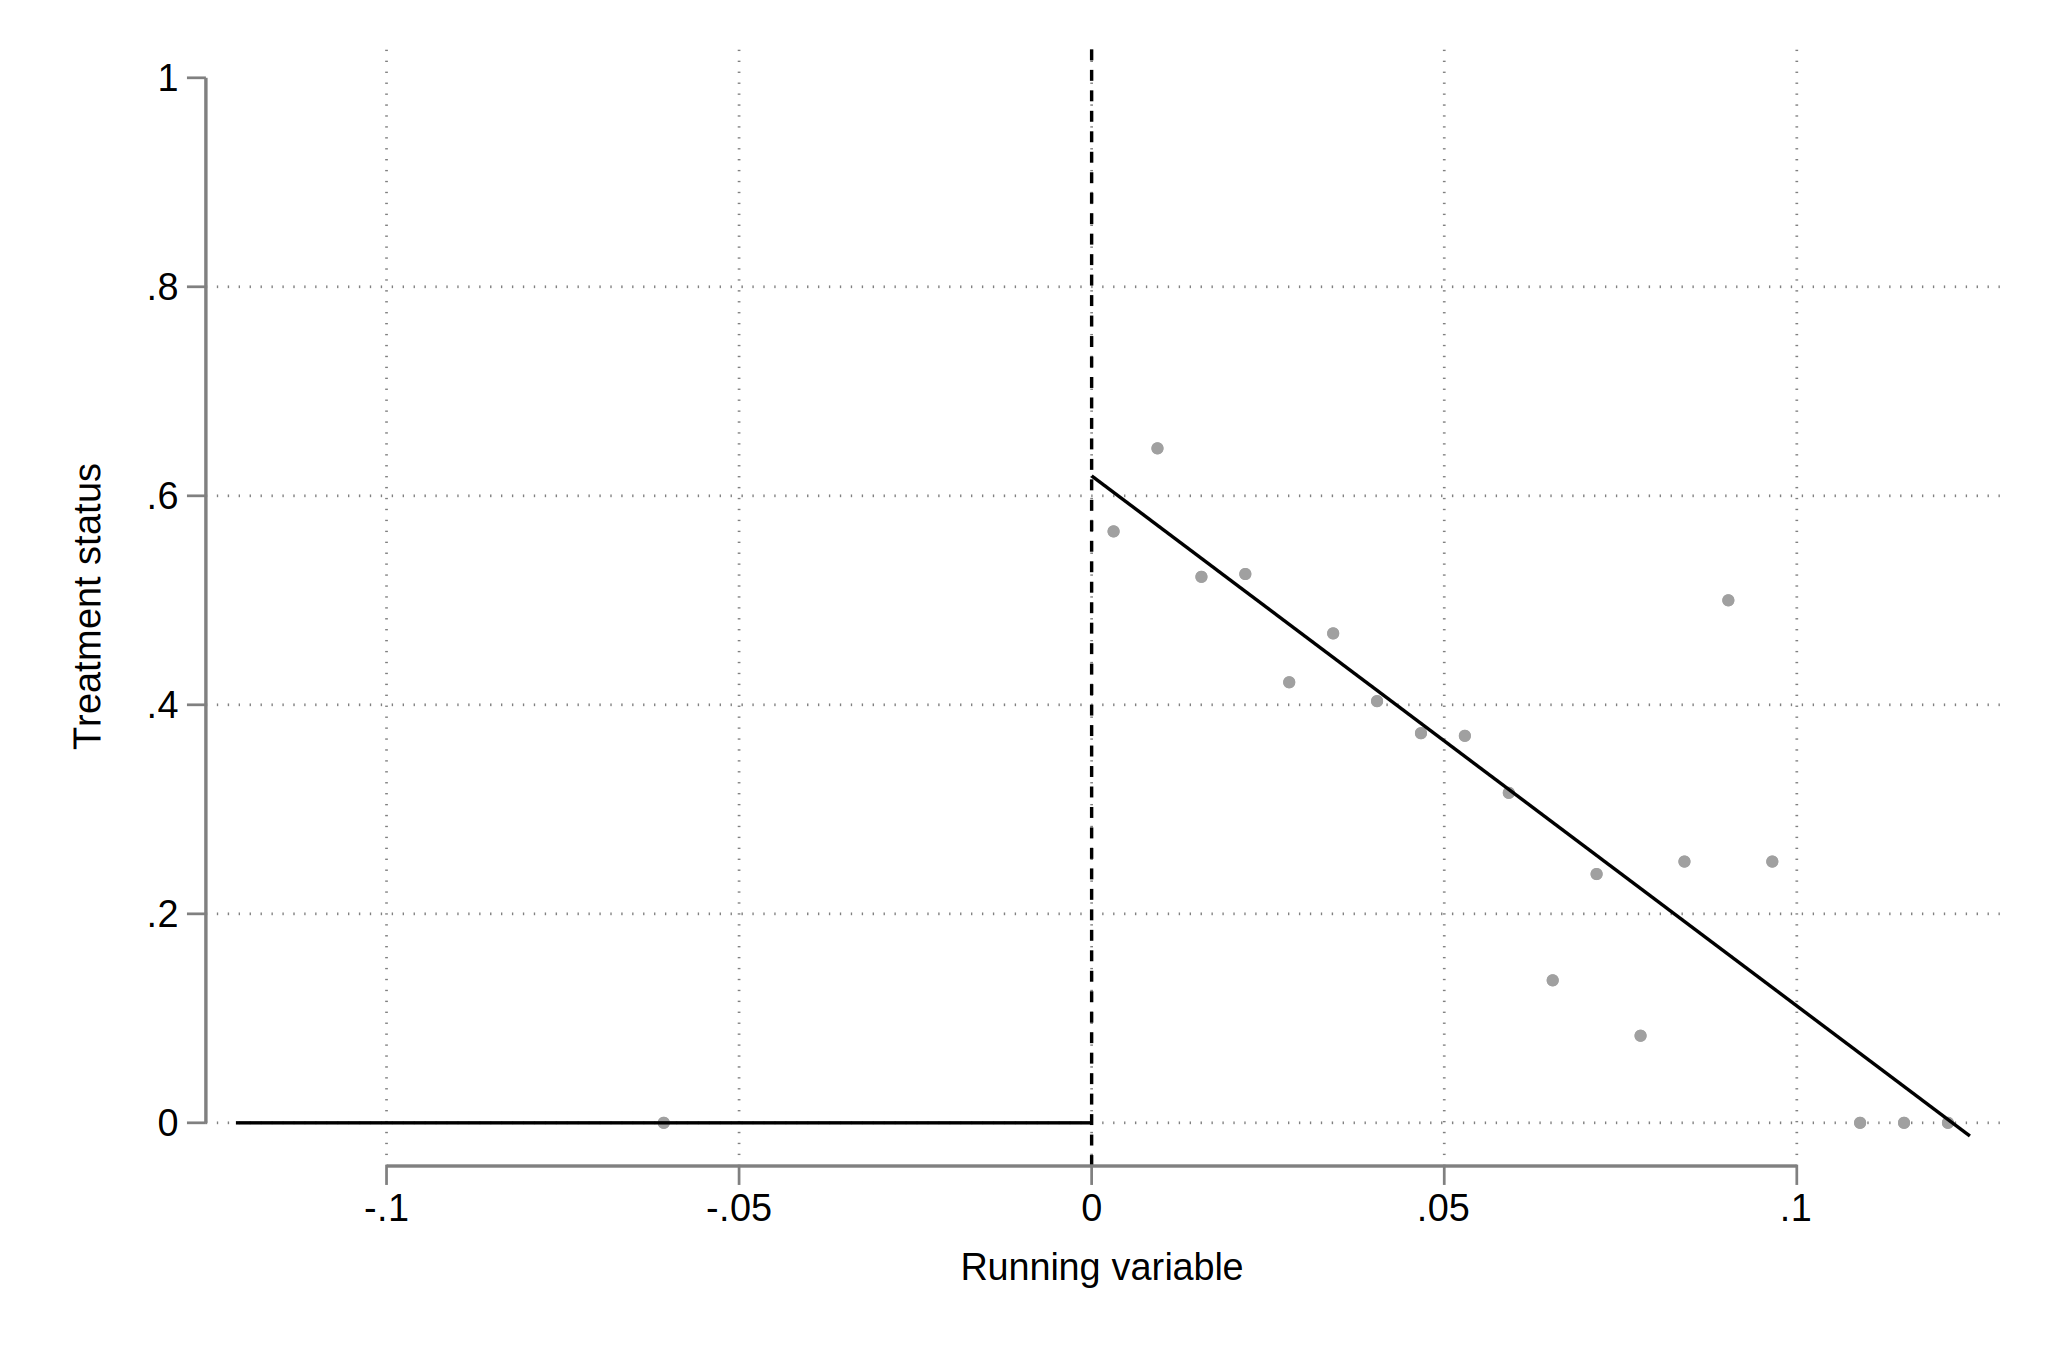

In [43]:
%%stata

// Let's plot some stuff so we get an idea of what's happening
// First, the "first stage"
rdplot treatment running, p(1) graph_options(title("") ///
    ytitle(Treatment status) xtitle(Running variable) graphregion(color(white)) ///
    legend(off) ylabel(0 (.2) 1) xlabel(-.1 (.05) .1))) nbins(20 20)
// Note how we don't have perfect compliance. Not all candidates who get more than
// 12.5% end up running in the second round


. 
. // Second, let's look at one of the outcomes 
. rdplot turnout running,  fuzzy(treatment) nbins(30 30) p(2). graph_options(ti
> tle("") legend(off) ///
>     ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(co
> lor(white)) ylabel(.2(.2) 1) ///
>     xlabel(-.15 (.05) .15))) 

RD Plot with RD plot with manually set number of bins.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       725
> 7
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |      6042        1215
   Eff. Number of obs |      6041        1215
  Order poly. fit (p) |         2           2
     BW poly. fit (h) |     0.121       0.125
 Number of bins scale |     1.000       1.000

Outcome: turnout. Running variable: running.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        30          30
   Average

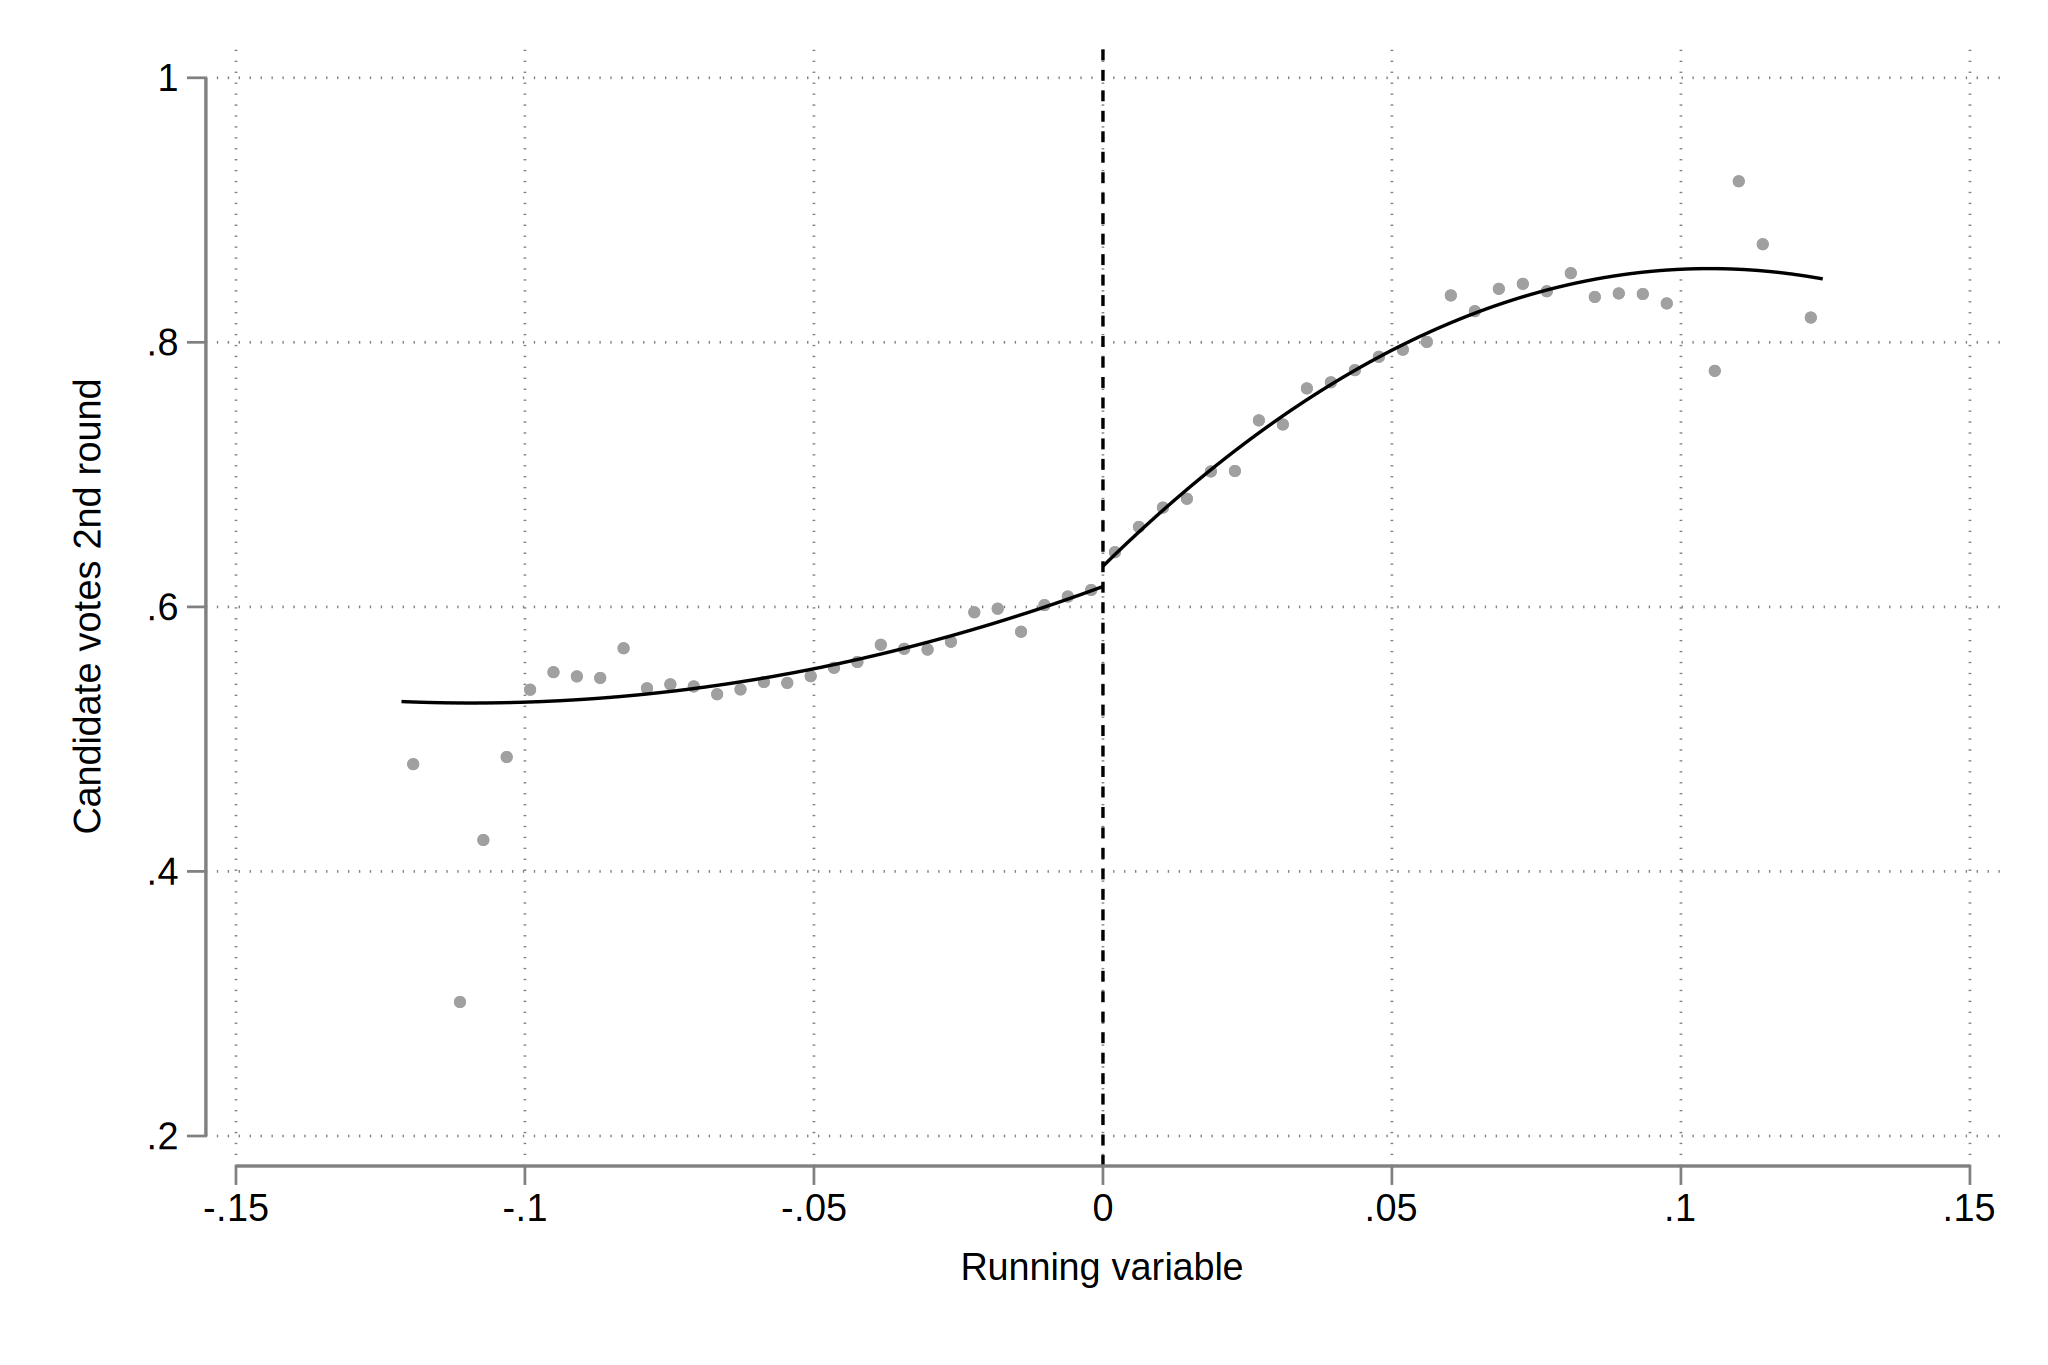

In [44]:
%%stata

// Second, let's look at one of the outcomes 
rdplot turnout running,  fuzzy(treatment) nbins(30 30) p(2). graph_options(title("") legend(off) ///
    ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(color(white)) ylabel(.2(.2) 1) ///
    xlabel(-.15 (.05) .15))) 
// They're using nbins to define the bin width 


. 
. // We can also add confidence intervals:
. rdplot turnout running,  fuzzy(treatment) nbins(30 30) p(2). graph_options(ti
> tle("") legend(off) ///
>     ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(co
> lor(white)) ylabel(.2(.2) 1) ///
>     xlabel(-.15 (.05) .15))) ci(95) shade 

RD Plot with RD plot with manually set number of bins.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       725
> 7
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |      6042        1215
   Eff. Number of obs |      6041        1215
  Order poly. fit (p) |         2           2
     BW poly. fit (h) |     0.121       0.125
 Number of bins scale |     1.000       1.000

Outcome: turnout. Running variable: running.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        30          30
  

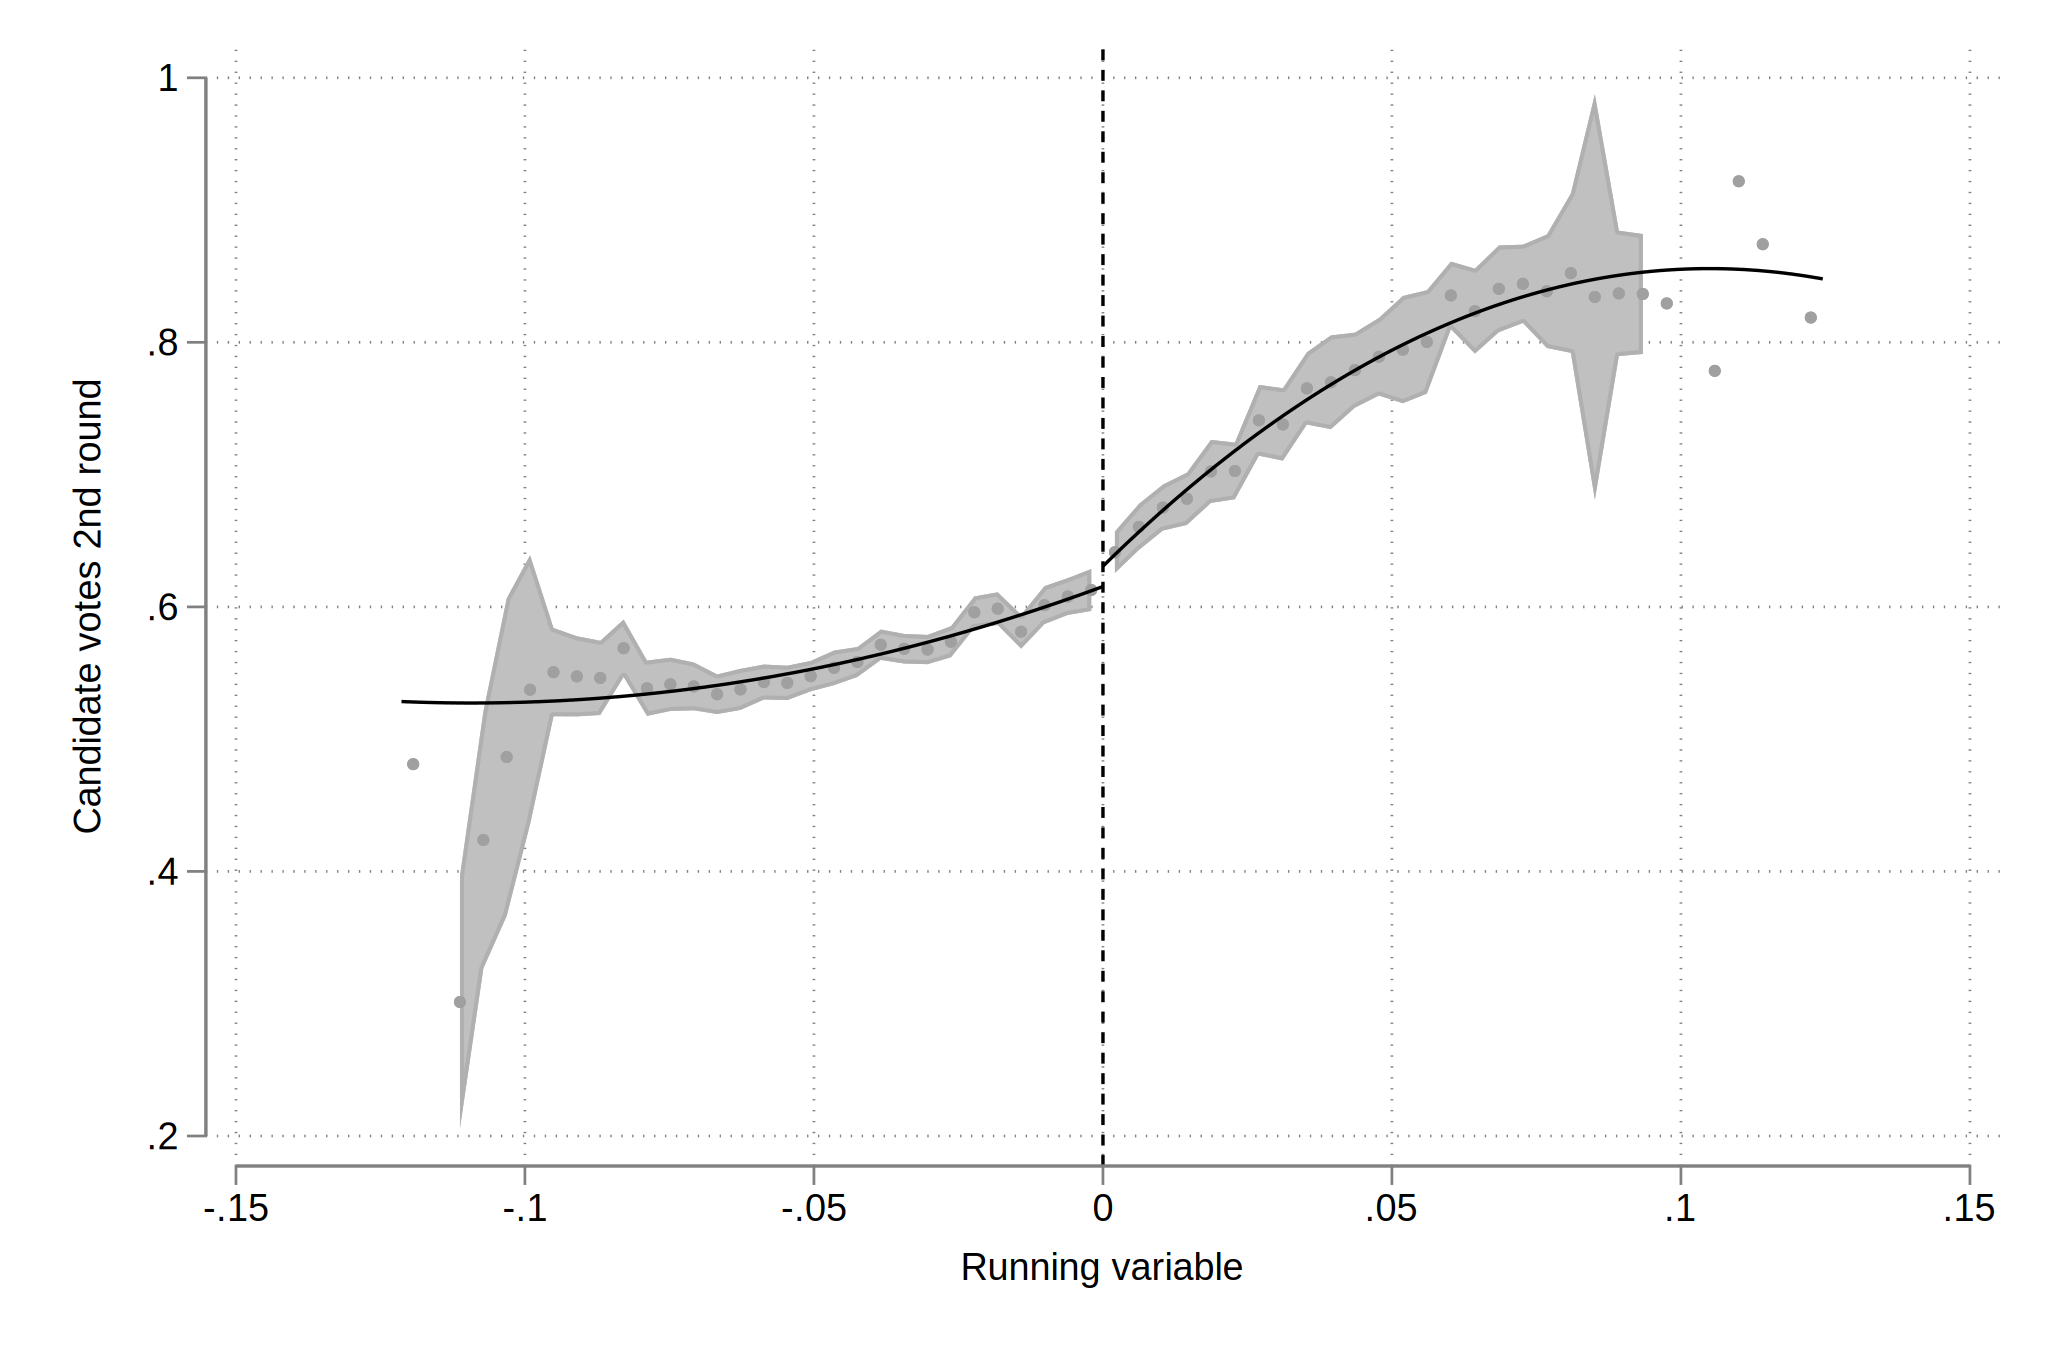

In [45]:
%%stata

// We can also add confidence intervals:
rdplot turnout running,  fuzzy(treatment) nbins(30 30) p(2). graph_options(title("") legend(off) ///
    ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(color(white)) ylabel(.2(.2) 1) ///
    xlabel(-.15 (.05) .15))) ci(95) shade 


. 
. rdplot turnout running,  nbins(30 30) p(2). graph_options(title("") legend(of
> f) ///
>     ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(co
> lor(white)) ylabel(.2(.2) 1) ///
>     xlabel(-.15 (.05) .15)))

RD Plot with RD plot with manually set number of bins.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       725
> 7
----------------------+----------------------        Kernel         =    Unifor
> m
        Number of obs |      6042        1215
   Eff. Number of obs |      6041        1215
  Order poly. fit (p) |         2           2
     BW poly. fit (h) |     0.121       0.125
 Number of bins scale |     1.000       1.000

Outcome: turnout. Running variable: running.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        30          30
   Average bin length |     0.004       0.004
    Median bin length |     0.

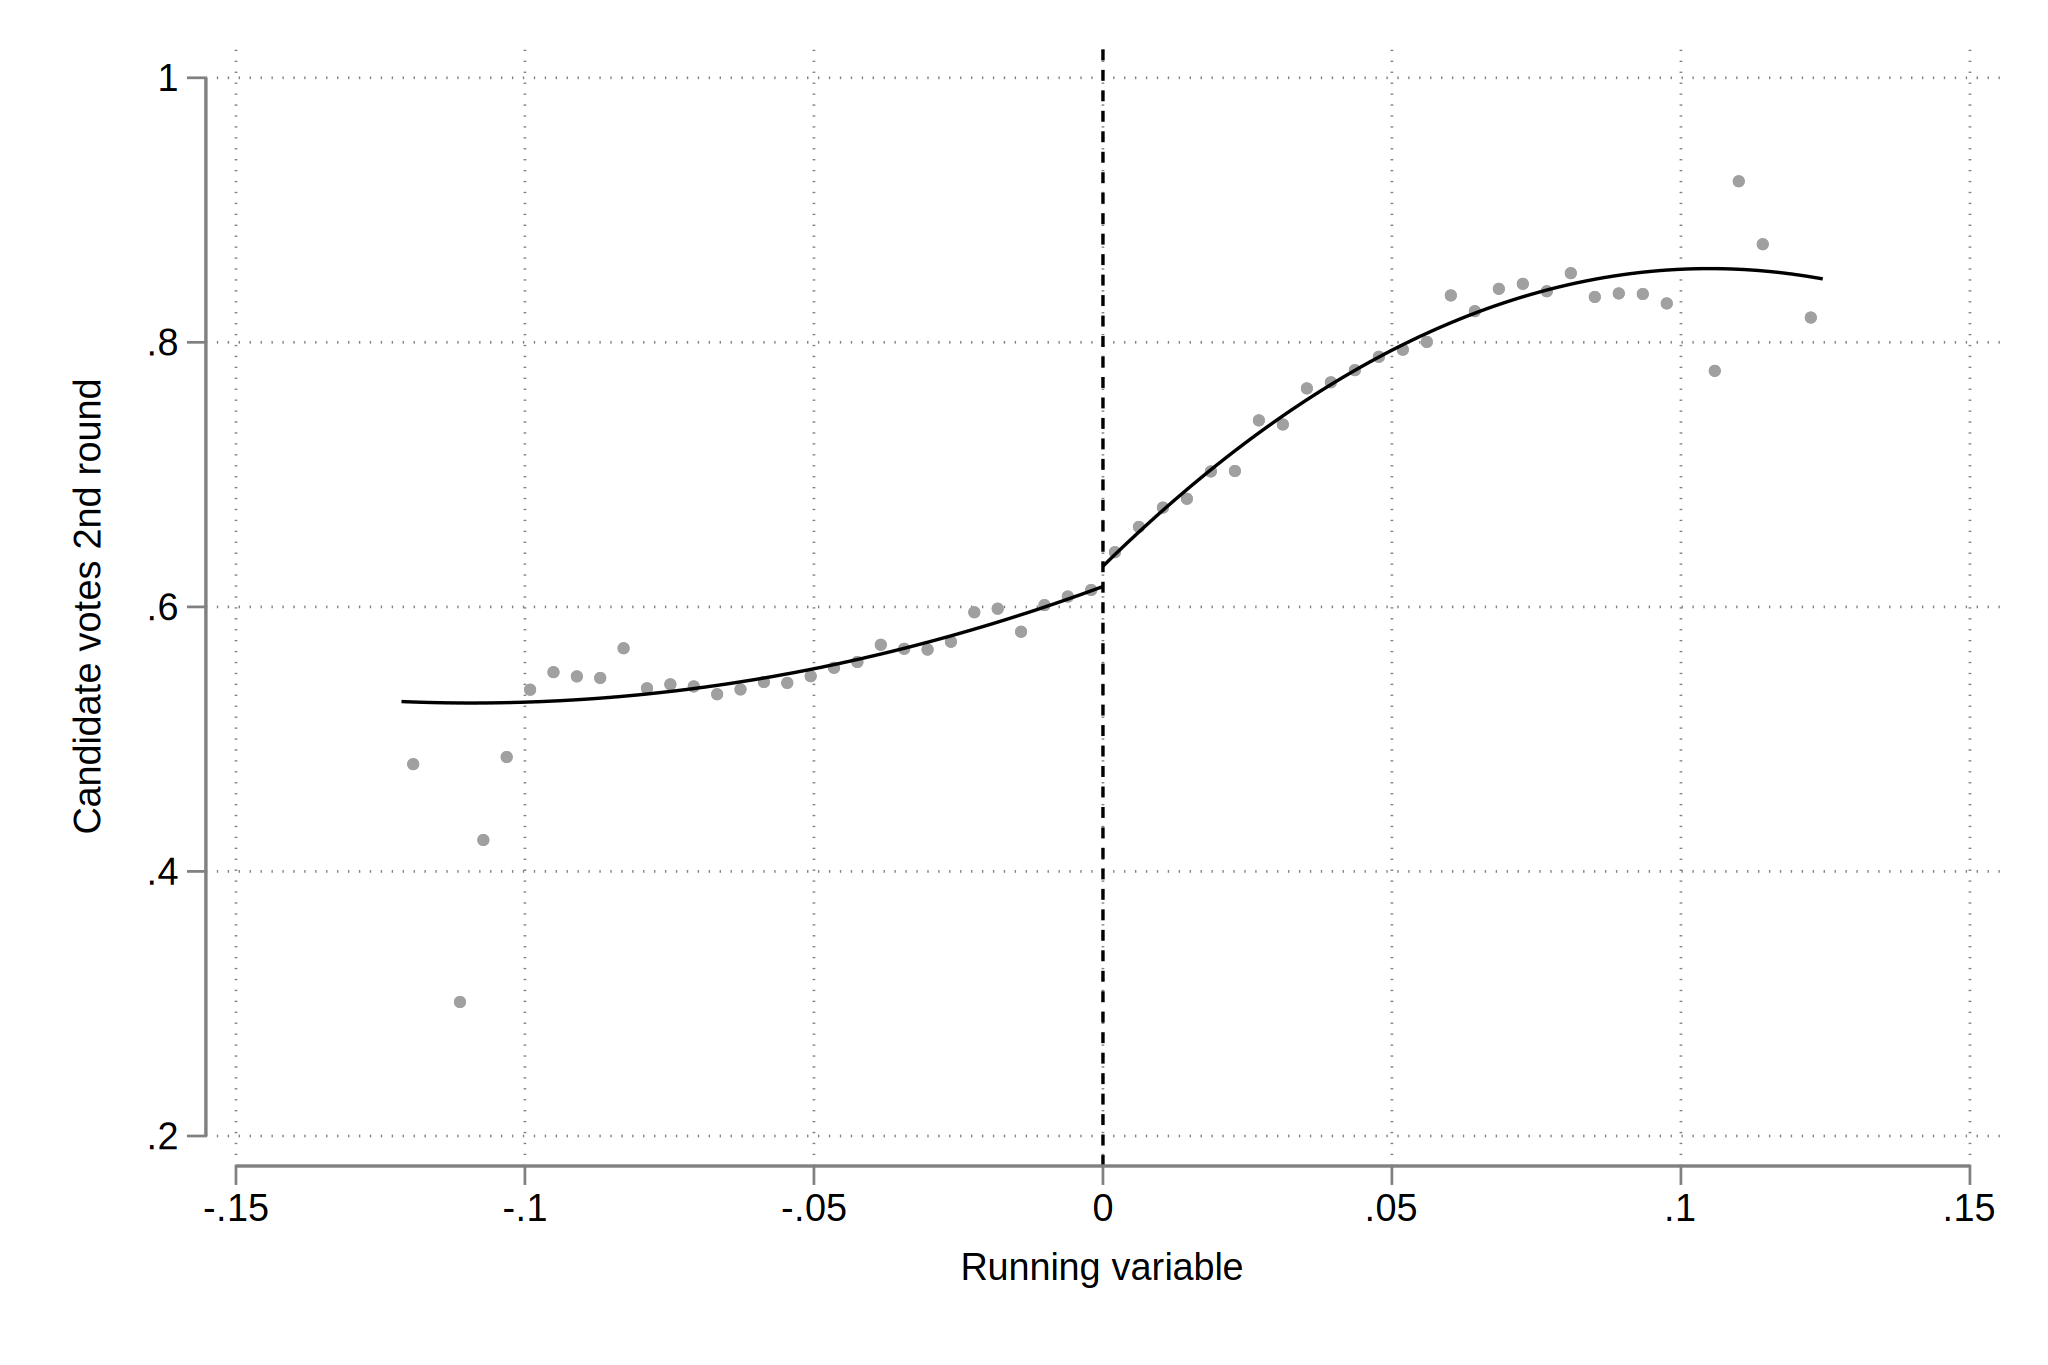

In [46]:
%%stata 

rdplot turnout running,  nbins(30 30) p(2). graph_options(title("") legend(off) ///
    ytitle(Candidate votes 2nd round) xtitle(Running variable) graphregion(color(white)) ylabel(.2(.2) 1) ///
    xlabel(-.15 (.05) .15)))
// Here I just want to show that including the "fuzzy" option doesn't change anything here

ereturn list


In [47]:
%%stata

// Replicate and generate table 3, then add a panel below using the 2sls estimates
eststo rdrob_turn: rdrobust turnout running, fuzzy(treatment) 
    estadd scalar obs=e(N_h_l)+e(N_h_r)
    estadd scalar pval = e(pv_rb)
    estadd scalar poly = e(p)
    estadd scalar BW = e(h_r)
    estadd local bws = e(bwselect)
sum turnout if assignment==0 & abs(running)<= e(h_r)
local mean_control=r(mean)
    estadd scalar mean_con = `mean_control'


. 
. // Replicate and generate table 3, then add a panel below using the 2sls esti
> mates
. eststo rdrob_turn: rdrobust turnout running, fuzzy(treatment) 

Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       725
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      6042        1215            Kernel        = Triangula
> r
Eff. Number of obs |      1528         770            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.025       0.025
       BW bias (b) |     0.038       0.038
         rho (h/b) |     0.650       0.650

First-stage estimates. Outcome: treatment. Running variable: running.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
>

In [48]:
%%stata

eststo rdrob_blank: rdrobust blanknull running, fuzzy(treatment) 
    estadd scalar obs=e(N_h_l)+e(N_h_r)
    estadd scalar pval = e(pv_rb)
    estadd scalar poly = e(p)
    estadd scalar BW = e(h_r)
    estadd local bws = e(bwselect)
sum blanknull if assignment==0 & abs(running)<= e(h_r)
local mean_control=r(mean)
    estadd scalar mean_con = `mean_control'


. 
. eststo rdrob_blank: rdrobust blanknull running, fuzzy(treatment) 

Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       725
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      6042        1215            Kernel        = Triangula
> r
Eff. Number of obs |      1797         833            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.028       0.028
       BW bias (b) |     0.050       0.050
         rho (h/b) |     0.571       0.571

First-stage estimates. Outcome: treatment. Running variable: running.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> 

In [49]:
%%stata

eststo rdrob_cand: rdrobust candvotes  running, fuzzy(treatment) 
    estadd scalar mean_control=r(mean)
    estadd scalar obs=e(N_h_l)+e(N_h_r)
    estadd scalar pval = e(pv_rb)
    estadd scalar poly = e(p)
    estadd scalar BW = e(h_r)
    estadd local bws = e(bwselect)
sum candvotes if assignment==0 & abs(running)<= e(h_r)
local mean_control=r(mean)
    estadd scalar mean_con = `mean_control'


. 
. eststo rdrob_cand: rdrobust candvotes  running, fuzzy(treatment) 

Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       725
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      6042        1215            Kernel        = Triangula
> r
Eff. Number of obs |      1589         785            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.026       0.026
       BW bias (b) |     0.039       0.039
         rho (h/b) |     0.654       0.654

First-stage estimates. Outcome: treatment. Running variable: running.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval
> ]
-------------------+-----------------------------------------------------------
> 

In [50]:
%%stata

eststo rdrob_cand_yr: xi: rdrobust candvotes  running, fuzzy(treatment) covs(i.year)


. 
. eststo rdrob_cand_yr: xi: rdrobust candvotes  running, fuzzy(treatment) covs(
> i.year)
i.year            _Iyear_1978-2015    (naturally coded; _Iyear_1978 omitted)

Covariate-adjusted Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       725
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      6042        1215            Kernel        = Triangula
> r
Eff. Number of obs |      1431         744            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.024       0.024
       BW bias (b) |     0.035       0.035
         rho (h/b) |     0.675       0.675

First-stage estimates. Outcome: treatment. Running variable: running.
-------------------------------------------------------------------------------
> -
            Method |   Coef.    Std. Err.    z  

In [51]:
%%stata

ereturn list


. 
. ereturn list

scalars:
           e(tau_bc_r) =  .8165947836037741
           e(tau_bc_l) =  .7748693698231814
             e(tau_bc) =  .0729837040558376
           e(tau_cl_r) =  .81846779068125
           e(tau_cl_l) =  .7755579708254734
             e(tau_cl) =  .072113068769439
                e(b_r) =  .0348769315125188
                e(b_l) =  .0348769315125188
                e(h_r) =  .0235488917007855
                e(h_l) =  .0235488917007855
                  e(q) =  2
                  e(p) =  1
                  e(c) =  0
              e(N_b_r) =  921
              e(N_b_l) =  2356
              e(N_h_r) =  744
              e(N_h_l) =  1431
                e(N_r) =  1215
                e(N_l) =  6042
                  e(N) =  7257
         e(tau_T_bc_r) =  .3040963725414516
         e(tau_T_bc_l) =  -.2673306347250141
         e(tau_T_cl_r) =  .3256041688418827
         e(tau_T_cl_l) =  -.2694311082306912
        e(se_tau_T_rb) =  .0403837382917276
        e(se_

In [52]:
%%stata

// Now I want to show you how to account for covariates in the rdrobust command	
eststo rdrob_cand_yr: xi: rdrobust candvotes  running, fuzzy(treatment) covs(i.year)
    estadd scalar mean_control=r(mean)
    estadd scalar obs=e(N_h_l)+e(N_h_r)
    estadd scalar pval = e(pv_rb)
    estadd scalar poly = e(p)
    estadd scalar BW = e(h_r)
    estadd local bws = e(bwselect)
sum candvotes if assignment==0 & abs(running)<= e(h_r)
local mean_control=r(mean)
    estadd scalar mean_con = `mean_control'


. 
. // Now I want to show you how to account for covariates in the rdrobust comma
> nd 
. eststo rdrob_cand_yr: xi: rdrobust candvotes  running, fuzzy(treatment) covs(
> i.year)
i.year            _Iyear_1978-2015    (naturally coded; _Iyear_1978 omitted)

Covariate-adjusted Fuzzy RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       725
> 7
-------------------+----------------------            BW type       =      mser
> d
     Number of obs |      6042        1215            Kernel        = Triangula
> r
Eff. Number of obs |      1431         744            VCE method    =         N
> N
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     0.024       0.024
       BW bias (b) |     0.035       0.035
         rho (h/b) |     0.675       0.675

First-stage estimates. Outcome: treatment. Running variable: running.
----------------------------------------------

In [53]:
%%stata

cd "${latex}"

esttab rdrob_turn rdrob_blank rdrob_cand rdrob_cand_yr using "table2.tex",  sfmt(4) b(3) se(2) ///
varlabel(RD_Estimate "3rd. Present") ///
scalars("pval Robust p-value" "obs Observations" "poly Polyn. Order" "BW Bandwidth" "bws Band. method" "mean_con Mean, left of the threshold") ///
label mtitles("Turnout" "Null and Blank Votes" "Candidate Votes") noobs compress ///
posthead("\hline \\ \multicolumn{2}{c}{\textbf{Panel A: RD Robust Estimates}}\\\\ [-1ex]") ///
fragment /// This fragment will allow you to append a second panel below
replace

// fragment tells stata that there will be more esttab's coming to append a table
// noobs tells stata not to show the normal Observation count
// compress : I don't know exactly what it does, but the tables look bad without it
// posthead is some LaTex stuff that I don't really understand, but I copy and edit as I need it


. 
. cd "${latex}"
/Users/brunokomel/Library/CloudStorage/Dropbox/Apps/Overleaf/Recitation - Table
> s

. 
. esttab rdrob_turn rdrob_blank rdrob_cand rdrob_cand_yr using "table2.tex",  s
> fmt(4) b(3) se(2) ///
> varlabel(RD_Estimate "3rd. Present") ///
> scalars("pval Robust p-value" "obs Observations" "poly Polyn. Order" "BW Band
> width" "bws Band. method" "mean_con Mean, left of the threshold") ///
> label mtitles("Turnout" "Null and Blank Votes" "Candidate Votes") noobs compr
> ess ///
> posthead("\hline \\ \multicolumn{2}{c}{\textbf{Panel A: RD Robust Estimates}}
> \\\\ [-1ex]") ///
> fragment /// This fragment will allow you to append a second panel below
> replace
(file table2.tex not found)
(output written to table2.tex)

. 
. // fragment tells stata that there will be more esttab's coming to append a t
> able
. // noobs tells stata not to show the normal Observation count
. // compress : I don't know exactly what it does, but the tables look bad with
> out it
. // posthead i

In [54]:
%%stata

// Note here that you will have to make a choice of bandwidth. I chose 0.02, because there were still enough observations on both sides to get significant estimates (and it's close to the optimal bandwidth above)
eststo iv_turn: ivreg2  turnout running (treatment  = assignment) if running >= -0.02 & running <= 0.02

eststo iv_blank: ivreg2  blanknull running (treatment  = assignment) ///
if running >= -0.02 & running <= 0.02

eststo iv_cand_year: ivreg2  candvotes running (treatment  = assignment) ///
if running >= -0.02 & running <= 0.02

eststo iv_cand_year2: xi: ivreg2 candvotes running (treatment  = assignment) ///
i.year if running >= -0.02 & running <= 0.02



. 
. // Note here that you will have to make a choice of bandwidth. I chose 0.02, 
> because there were still enough observations on both sides to get significant
>  estimates (and it's close to the optimal bandwidth above)
. eststo iv_turn: ivreg2  turnout running (treatment  = assignment) if running 
> >= -0.02 & running <= 0.02

IV (2SLS) estimation
--------------------

Estimates efficient for homoskedasticity only
Statistics consistent for homoskedasticity only

                                                      Number of obs =     1817
                                                      F(  2,  1814) =    88.85
                                                      Prob > F      =   0.0000
Total (centered) SS     =  23.05657931                Centered R2   =   0.0127
Total (uncentered) SS   =  731.4354771                Uncentered R2 =   0.9689
Residual SS             =  22.76290991                Root MSE      =    .1119

----------------------------------------------------

                                         20% maximal IV size              6.66
                                         25% maximal IV size              5.53
Source: Stock-Yogo (2005).  Reproduced by permission.
------------------------------------------------------------------------------
Sargan statistic (overidentification test of all instruments):           0.000
                                                 (equation exactly identified)
------------------------------------------------------------------------------
Instrumented:         treatment
Included instruments: running _Iyear_1981 _Iyear_1988 _Iyear_1993 _Iyear_1997
                      _Iyear_2002 _Iyear_2007 _Iyear_2011 _Iyear_2012
                      _Iyear_2015
Excluded instruments: assignment
------------------------------------------------------------------------------

. 


In [55]:
%%stata

esttab iv_* using "table2.tex", sfmt(4) b(3) se(2) keep(treatment) varlabel(treatment "3rd. Present") /// 
nomtitles booktabs nonumbers compress ///
posthead("\hline \\ \multicolumn{2}{c}{\textbf{Panel B: IV Estimates}}\\\\ [-1ex] ") ///
fragment ///
append 

// append here is the key that forces these estimates into the table we previously created, and called "using ..."
// nonumbers takes out the column numbers, which we don't need because we already have them in the table above



. 
. esttab iv_* using "table2.tex", sfmt(4) b(3) se(2) keep(treatment) varlabel(t
> reatment "3rd. Present") /// 
> nomtitles booktabs nonumbers compress ///
> posthead("\hline \\ \multicolumn{2}{c}{\textbf{Panel B: IV Estimates}}\\\\ [-
> 1ex] ") ///
> fragment ///
> append 
(output written to table2.tex)

. 
. // append here is the key that forces these estimates into the table we previ
> ously created, and called "using ..."
. // nonumbers takes out the column numbers, which we don't need because we alr
> eady have them in the table above
. 
